In [1]:
from collections import defaultdict, OrderedDict
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from geopy.distance import vincenty
import json
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import time

# Uncomment this to make the plots inline!
%matplotlib inline

# Turn off chained assignment warning
pd.options.mode.chained_assignment = None

In [2]:
INPUT_PATH = 'inputs/'
OUTPUT_PATH = 'outputs_1/'

# for conveniently holding data
class Data(object):  
    pass

results = Data()

In [3]:
def dictionary_to_csv(dictionary, file_name):
    """Convert a dictionary to a csv with a column of keys and a column of values"""
    
    csv = ''
    for k, v in dictionary.items():
        
        csv +=  '{},{}'.format(k, v) + '\n'
    
    with open(file_name, 'w') as _file:
        _file.write(csv)

# Filter out reports of flooding

In [4]:
def load_data():
    """
    Load 311 data, check how many rows have a value for which location
    columns and select only relevant columns
    """

    data = pd.read_csv('inputs/311_Service_Requests_from_2015.csv')

    # A fifth of these have no address, so the 1/10th with no latitude is probably as good as it gets.
    print('Fraction of reports with attribute')
    for col in ['Incident Address', 'Latitude', 'Longitude', 'Descriptor']:
        print(col + '\t' + str(data[col].isnull().mean()))

    select_cols = ['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type',
                   'Descriptor', 'Latitude', 'Longitude']
    data[select_cols].to_csv(open(INPUT_PATH + '311_Service_Requests_from_2015_short.csv', 'w'), index=False)


def filter_311(d):
    """
    We find that Complaint Types with descriptors containing "flood" can be either "Sewer",
    "Public Toilet" or some sort of lighting. By inspection, only Sewer is relevant.
    """

    flood_data = d[(d.Descriptor.fillna('').str.lower().str.contains('flood'))
                      & (d['Complaint Type'] == 'Sewer')
                      & (d.Latitude.notnull())]

    # clean up column names
    flood_data.columns = [col.lower().replace(' ', '_') for col in flood_data.columns]

    flood_data.created_date = pd.to_datetime(flood_data.created_date)

    flood_data.to_csv(INPUT_PATH + '311_2015_flood_reports.csv', index=False)

In [5]:
if '311_2015_flood_reports.csv' in os.listdir(INPUT_PATH):
    print("Using existing 311_2015_flood_reports.csv")
else:
    load_data()
    filter_311(pd.read_csv(INPUT_PATH + '311_2015_short.csv'))
    # ignore DtypeWarning

Using existing 311_2015_flood_reports.csv


# Load data

In [6]:
flood_reports = pd.read_csv(INPUT_PATH + '311_2015_flood_reports.csv', parse_dates=[1])

In [7]:
flood_reports.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,latitude,longitude
0,30740992,2015-05-31 19:19:00,06/18/2015 08:30:00 AM,Sewer,Street Flooding (SJ),40.709027,-73.780835
1,30957585,2015-06-28 06:41:00,06/29/2016 10:10:00 AM,Sewer,Street Flooding (SJ),40.672068,-73.777982
2,30958236,2015-06-28 07:05:00,07/15/2015 11:20:00 AM,Sewer,Street Flooding (SJ),40.665102,-73.738892
3,31502955,2015-09-10 18:58:00,09/18/2015 10:53:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.656512,-73.834222
4,31861036,2015-10-28 11:12:00,11/12/2015 09:00:00 AM,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),40.576310,-73.857053


In [8]:
results.n_311_flooding_reports = flood_reports.shape[0]
flood_reports.shape

(9188, 7)

# Examine possible distortions

In [9]:
def distortion(data):
    """
    Since we will simply use the raw longitude and latitude in our clustering, we want to understand
    how the "distances" found will translate to actual miles.
    """
    
    latitude_min, latitude_max = data.latitude.min(), data.latitude.max()
    longitude_min, longitude_max = data.longitude.min(), data.longitude.max()
    
    # Use the vincenty distance, which calculates distance correctly for longitude and latitude
    lat_miles = vincenty((latitude_max, longitude_min), (latitude_min, longitude_min)).miles
    lat_degrees = latitude_max - latitude_min
    
    lon_miles = vincenty((latitude_max, longitude_min), (latitude_max, longitude_max)).miles
    lon_degrees = longitude_max - longitude_min
    
    miles_per_degree_lat = lat_miles/lat_degrees
    miles_per_degree_lon = lon_miles/lon_degrees
    
    print("There are {} miles per degree latitude".format(miles_per_degree_lat))
    print("There are {} miles per degree longitude".format(miles_per_degree_lon))
    
    return miles_per_degree_lat, miles_per_degree_lon

In [10]:
results.miles_per_degree_lat, results.miles_per_degree_lon = distortion(flood_reports)

There are 69.00217007583774 miles per degree latitude
There are 52.34791169782939 miles per degree longitude


# Identifying storm periods

In [11]:
# number of reports of flooding per day required to qualify that day as part of a storm period
storm_period_threshold = 50

In [12]:
# How many days of the year have flooding data?
flood_reports.created_date.dt.dayofyear.nunique()

363

In [13]:
def plot_flood_reports(data):
    """
    Plot the number of flood reports per day for the year
    
    NB: A couple days might be missing from this plot because they had zero reports of flooding
    """
    
    plt.figure(figsize=(8, 2))
    plt.plot(data.groupby(data.created_date.dt.dayofyear).size(), '.-')
    plt.axhline(storm_period_threshold, color='black', linestyle='dashed')
    plt.xlabel('Day of year')
    plt.xlim(0, 365)
    plt.ylabel('Number of flooding reports')
    plt.savefig(OUTPUT_PATH + 'flood_reports.png', dpi=200, bbox_inches='tight')

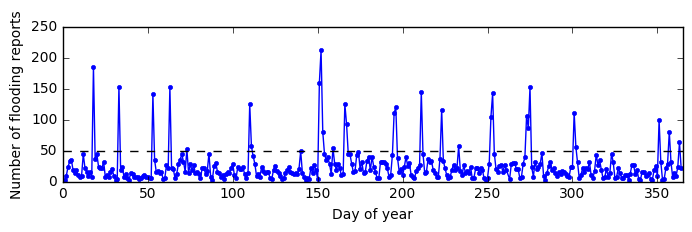

In [14]:
plot_flood_reports(flood_reports)

In [15]:
def get_storm_periods(data):
    """
    Aggregate those consecutive days of the year with more than 50 reports of flooding. We call these
    "storm periods", each numbered with a storm number.
    """
    
    is_storm_periods = flood_reports.groupby(data.created_date.dt.dayofyear).size() > storm_period_threshold
    
    storm_periods = defaultdict(list)
    i = 0
    is_yesterday = False
    
    for today, is_today in zip(is_storm_periods.index, is_storm_periods):
        
        # if today's not a storm period, but yesterday was, a storm period has just concluded
        if not is_today and is_yesterday:
            i += 1
        
        if is_today:
            storm_periods[i].append(today)
            
        is_yesterday = is_today
    
    results.number_of_storm_periods = len(storm_periods)
    
    return storm_periods

In [16]:
storm_periods = get_storm_periods(flood_reports)

# Clustering within storm periods to identify floods

In [17]:
def cluster_attributes(cluster):
    """
    Given a cluster, a DataFrame containing the reports consituting a cluster, return some essential
    statistics about that cluster: the earliest report, the latest report, the center of the cluster, 
    the cluster's approximate diameter, the duration from the earliest to latest report, and the number
    of reports in the cluster.
    """
    
    latitude_max = cluster.latitude.max()
    latitude_min = cluster.latitude.min()
    longitude_max = cluster.longitude.max()
    longitude_min = cluster.longitude.min()
    
    space_diameter = vincenty((latitude_max, longitude_min), (latitude_min, longitude_max)).miles    
   
    time_diameter = cluster.created_date.max() - cluster.created_date.min()
    
    time_start = cluster.created_date.min()
    time_end = cluster.created_date.max()
    
    space_center_latitude = cluster.latitude.mean()
    space_center_longitude = cluster.longitude.mean()    
    
    # this is set to a constant for the cluster by definition. We just need the value
    storm_number = cluster.storm_number.max()
    
    return [time_start, time_end, space_center_latitude, space_center_longitude,
            space_diameter, time_diameter, cluster.shape[0], storm_number]

In [18]:
def cluster_storms(_eps, _flood_reports, _storm_periods):
    """
    Apply DBSCAN clustering to reports, _flood_reports, from each storm period, _storm_periods
    using eps.
    """
    
    minimum_flood_reports = 5
    
    floods = []
    # count the total number of outlier point encountered
    n_outliers = 0
    
    # loop through a dictionary of an index for the storm periods keyed to a set of days belonging
    # to that storm period
    for storm_number, storm_days in _storm_periods.items():
        
        # select the flood reports from days within this storm period
        storm_flood_reports = _flood_reports[_flood_reports.created_date.dt.dayofyear.isin(set(storm_days))]
        
        # take longitude and latitude and convert to matrix for sklearn
        storm_flood_reports_matrix = storm_flood_reports[['latitude', 'longitude']].as_matrix()
        
        # create an instance of the DBSCAN clustering algorithm
        dbscan = DBSCAN(eps=_eps, min_samples=minimum_flood_reports)
        
        # predict the cluster of each storm report 
        storm_flood_reports['cluster'] = dbscan.fit_predict(storm_flood_reports_matrix)
        
        # set the storm_number for all the reports
        storm_flood_reports['storm_number'] = storm_number

        # count the outlier reports, add them to the total and then remove them
        is_outlier = (storm_flood_reports.cluster == -1)
        n_outliers += is_outlier.sum()
        storm_flood_reports = storm_flood_reports[~is_outlier]
        
        # obtain statistics about each cluster
        storm_floods = list(storm_flood_reports.groupby('cluster').apply(cluster_attributes).values)
        
        floods.extend(storm_floods)
    
    headers = ['time_start', 'time_end', 'latitude_center', 'longitude_center',
               'diameter', 'duration', 'number_of_reports', 'storm_number']
    
    floods = pd.DataFrame(floods, columns=headers)
    
    return floods, n_outliers

In [19]:
results.eps = 0.25/results.miles_per_degree_lat

flood_events, results.n_outliers = cluster_storms(results.eps, flood_reports, storm_periods)

results.n_floods = len(flood_events)

# index from 1 since this is what the rest of our analysis uses
flood_events.index += 1
flood_events.to_csv(OUTPUT_PATH + '311_2015_floods.csv')

# store our results as a table
dictionary_to_csv(results.__dict__, OUTPUT_PATH + 'results.csv')

In [20]:
def plot_floods(_flood_events, _flood_reports):
    """Plot the detected flood clusters"""
    """Sanity test by plotting all the reports of flooding. It looks like New York!"""
    
    plt.figure()
    plt.plot(_flood_reports['longitude'], _flood_reports['latitude'], '.', alpha=0.15, label="Flood reports")
    plt.plot(_flood_events['longitude_center'],
             _flood_events['latitude_center'], 'o', alpha=0.5, color='red', label="Flood events")
    plt.legend(loc='best')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.savefig(OUTPUT_PATH + 'flood_events_and_reports_by_location.png', dpi=200, bbox_inches='tight')

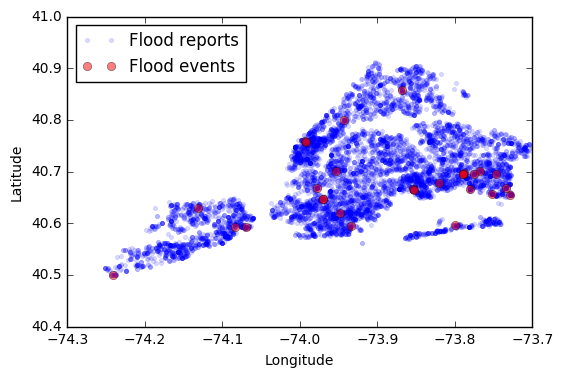

In [21]:
plot_floods(flood_events, flood_reports)

# Tweaking the clustering parameters

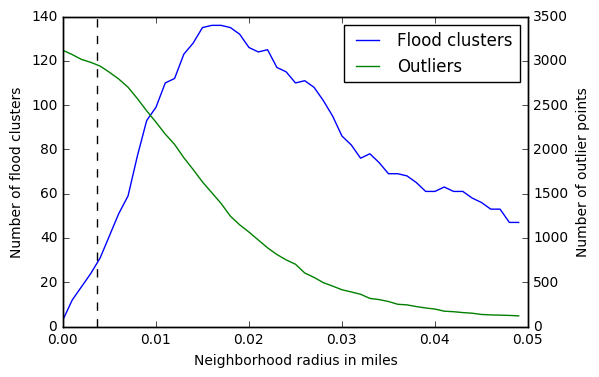

In [22]:
def cluster_storms_tune_eps(_flood_reports, _storm_periods):
    """Vary the eps parameter to show its effect on the number of clusters and outliers. Plot results."""
    
    n_clusters_by_eps = []
    n_outliers_by_eps = []

    eps_range = np.arange(0.00001, 0.050, 0.001)
    
    for eps in eps_range:
    
        _floods, n_outliers = cluster_storms(eps, _flood_reports, _storm_periods)
        
        n_clusters_by_eps.append(len(_floods))
        n_outliers_by_eps.append(n_outliers)
        
    plt.figure()
    plt.plot(eps_range, n_clusters_by_eps)
    plt.xlabel('Neighborhood radius in miles')
    plt.ylabel('Number of flood clusters')
    plt.axvline(0.25/results.miles_per_degree_lat, linestyle='dashed', color='black')
    
    plt.twinx()
    # spoof a line to get the label added to the legend
    plt.plot(np.nan, label='Flood clusters')
    plt.plot(eps_range, n_outliers_by_eps, color='green', label='Outliers')
    plt.ylabel('Number of outlier points')
    
    plt.legend()
    plt.savefig(OUTPUT_PATH + 'n_floods_n_outliers_by_esp.png', dpi=200, bbox_inches='tight')

cluster_storms_tune_eps(flood_reports, storm_periods)